## Named entity recognition (NER)
----


### Importing the data we need
----

In [12]:
%store -r game_text_cleaned
%store -r swords_text_cleaned

%store -r game_df_cleaned
%store -r swords_df_cleaned

In [13]:
# !pip install wikipedia
# !pip install --upgrade pip
# !pip install textacy
# !python3 -m spacy download en_core_web_lg
import pandas as pd
import spacy

nlp = spacy.load('en_core_web_lg')
nlp.max_length = 3000000

### Using Spacy to create a method extracting all the characters
-------

In [14]:
def get_characters(text_cleaned):
    
    text_string = ""
    for _list in text_cleaned:
        for string in _list:
            text_string += string + ' '
    
    characters_list = [{"name" : "Default", "count" : -1}]
    
    doc = nlp(text_string)
    for ent in doc.ents:
        index = next((i for i, item in enumerate(characters_list) if item["name"] == ent.text), None)
        if index is None and ent.label_ == "PERSON":
            characters_list.append({"name" : ent.text, "count" : 1});
        elif index is not None and ent.label_ == "PERSON":
            characters_list[index]["count"] += 1
    
    return characters_list

## Sort the obtained characters list
----
- We obtain something like [{}] --> list of dictionaries
- each dictionary has a field "name" and a field "count", therefore we will sort our dictionaries list by the count of the characters in reverse order (most common characters come first)

In [15]:
characters_list = get_characters(game_text_cleaned)
characters_list = sorted(characters_list, key=lambda x: x['count'], reverse=True)

In [16]:
print(characters_list)

[{'name': 'Tyrion', 'count': 1049}, {'name': 'Ned', 'count': 791}, {'name': 'Jon', 'count': 780}, {'name': 'Catelyn', 'count': 645}, {'name': 'Dany', 'count': 612}, {'name': 'Jaime', 'count': 445}, {'name': 'Robb', 'count': 411}, {'name': 'Robert', 'count': 341}, {'name': 'Arya', 'count': 304}, {'name': 'Joffrey', 'count': 259}, {'name': 'Sam', 'count': 259}, {'name': 'Stannis', 'count': 214}, {'name': 'Lannister', 'count': 203}, {'name': 'Cersei', 'count': 153}, {'name': 'Lysa', 'count': 147}, {'name': 'Luwin', 'count': 137}, {'name': 'Khal Drogo', 'count': 133}, {'name': 'Tywin', 'count': 114}, {'name': 'Rodrik', 'count': 108}, {'name': 'Bronn', 'count': 108}, {'name': 'Tyrion Lannister', 'count': 106}, {'name': 'Gregor', 'count': 90}, {'name': 'Brienne', 'count': 90}, {'name': 'Littlefinger', 'count': 88}, {'name': 'Grenn', 'count': 87}, {'name': 'Eddard Stark', 'count': 79}, {'name': 'Stark', 'count': 77}, {'name': 'Hodor', 'count': 71}, {'name': 'Jon Snow', 'count': 70}, {'name': 

## Create a method to manipulate our current character list
-----
- Now we have a list with all the characters, but we would like to get the n - connections between them so that we can make observations based on that
- Therfore, find_n_closest_characters takes the character_list and returns a list of tuples with [Character1, Character2, distance_between_them]

In [17]:
def find_n_closest_characters(character_list, text_cleaned, n):
    text_str = ""
    for _list in text_cleaned:
        for string in _list:
            text_str += string + ' '
    
    new_character_list = []
    for char1 in character_list:
        temp_characters = []
        index_c1 = text_str.find(char1["name"])
        if index_c1 >= 0:
            for char2 in character_list:
                if char1["name"] != char2["name"]:
                    idx_c2 = text_str.find(char2["name"], index_c1, len(text_str) - 1)
                    if idx_c2 > index_c1:
                        temp_characters.append((char1["name"], char2["name"], idx_c2 - index_c1))
            if temp_characters:
                temp_characters.sort(reverse=False, key = lambda x : x[2])
                new_character_list += temp_characters[:n]


    return new_character_list

In [18]:
n_characters = find_n_closest_characters(characters_list[:40], game_text_cleaned, 3)
print(n_characters)

[('Tyrion', 'Ned', 64), ('Tyrion', 'Robert', 453), ('Tyrion', 'Cersei', 659), ('Ned', 'Catelyn', 513), ('Ned', 'Catelyn Stark', 822), ('Ned', 'Stark', 830), ('Jon', 'Stark', 78), ('Jon', 'Starks', 78), ('Jon', 'Eddard Stark', 441), ('Catelyn', 'Ned', 690), ('Catelyn', 'Catelyn Stark', 1512), ('Catelyn', 'Stark', 1520), ('Dany', 'Viserys', 88), ('Dany', 'Khal Drogo', 555), ('Dany', 'Lannister', 1627), ('Jaime', 'Lannister', 6), ('Jaime', 'Sandor Clegane', 35), ('Jaime', 'Tyrion', 100), ('Robb', 'Mance', 25), ('Robb', 'Jon', 390), ('Robb', 'Stark', 468), ('Robert', 'Jon', 125), ('Robert', 'Jon Snow', 125), ('Robert', 'Robb', 465), ('Arya', 'Joffrey', 65), ('Arya', 'Jon', 81), ('Arya', 'Lannister', 264), ('Joffrey', 'Jon', 16), ('Joffrey', 'Lannister', 199), ('Joffrey', 'Jaime', 238), ('Sam', 'Jon', 72), ('Sam', 'Ned', 76), ('Sam', 'Grenn', 129), ('Stannis', 'Renly', 21), ('Stannis', 'Eddard Stark', 27), ('Stannis', 'Stark', 34), ('Lannister', 'Mormont', 6598), ('Lannister', 'Robb', 7023)

In [19]:
game_df = pd.DataFrame(n_characters, columns=["Character1", "Character2", "Distance"])
game_df

,Character1,Character2,Distance
0,Tyrion,Ned,64
1,Tyrion,Robert,453
2,Tyrion,Cersei,659
3,Ned,Catelyn,513
4,Ned,Catelyn Stark,822
...,...,...,...
115,Renly,Stark,13
116,Renly,Robert,19
117,Kevan,Tywin,13
118,Kevan,Ned,88


,Character1,Character2,Distance
0,Tyrion,Ned,64
1,Tyrion,Robert,453
2,Tyrion,Cersei,659
3,Ned,Catelyn,513
4,Ned,Catelyn Stark,822
...,...,...,...
115,Renly,Stark,13
116,Renly,Robert,19
117,Kevan,Tywin,13
118,Kevan,Ned,88


## Once we have all the data available we start graphing
-----

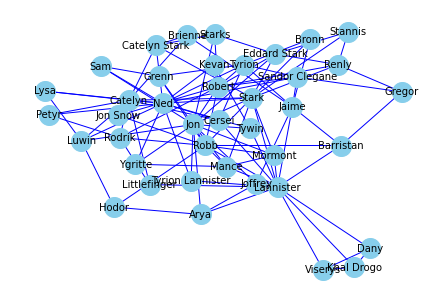

<Figure size 184320x103680 with 0 Axes>

In [22]:
import networkx as nx
from siuba import count

# Create our Graph object
game_df_graph = count(game_df.head(120), 'Character1','Character2', 'Distance', sort=True)
game_df_graph.drop(columns=['Distance'])
G = nx.from_pandas_edgelist(df=game_df_graph, source='Character1', target='Character2', edge_attr='n')

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Time to draw it
nx.draw(G, pos=nx.spring_layout(G, k=1.25, iterations=200), node_size=400, font_size=10, node_color='skyblue', edge_color='b', with_labels=True)
figure(figsize=(2560, 1440))

plt.show()